# Projet IMA 206 - Haze Removal

#### BARRANQUERO Margot, BERENGER Zoé


## Imports initiaux

In [1]:
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from PIL import Image

## Implémentation de l'article

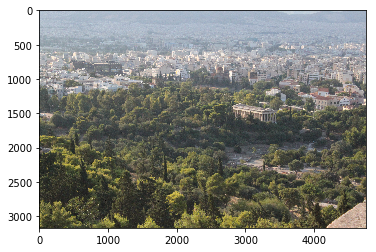

(333, 500, 3)

In [2]:
# Image de travail
image = mpimg.imread("MDataset/athenes.jpg")
plt.imshow(image)
plt.show()

# Réduire la taille de l'image si besoin pour que son plus grand côté fasse 500 pixels maximum
a = max(image.shape)/500
if (a < 1): a = 1

image = resize(image, (int(image.shape[0]/a), int(image.shape[1]/a)), mode='constant', anti_aliasing=True)
image.shape

### Mirror Padding

Remarque : lorsque les images en entrée ont un contour (gris sur les images de mon appareil photo, blanc sur le simages du Dataset) celui-ci devriendra visible ici.

In [3]:
def border_effects_continuity(im, patchsize, shape=3):
    """Mirror padding pour avoir une continuité sur les bords
    
    ARGUMENTS :
    im - image à agrandir
    patchsize - taille du patch qui sera appliqué sur l'image
    shape - profondeur de l'image (en couleur par défaut)
    """
    
    (N, M) = (im.shape[0], im.shape[1])
    p = math.floor(patchsize/2) #nombre de pixel ajouté de chaque côté de l'image
    
    # création de la nouvelle image agrandie vide
    img = np.zeros((N + 2*p, M + 2*p, shape), dtype=float)
    
    for i in range(N):
        for j in range(M):
            img[i + p][j + p] = im[i][j]
        
        # colonnes rajoutées
        for k in range(p):
            img[i + p][k] = im[i][p - k]
            img[i + p][M + p + k] = im[i][M - 1 - k]
    
    
    for j in range(M):
        #lignes rajoutées
        for k in range(p):
            img[k][j + p] = im[p - k][j]
            img[N + p + k][j + p] = im[N - 1 - k][j]
            
    #coins
    for i in range(p):
        for j in range(p):
            img[i][j] = im[p - i][p - j]
            img[N + p + i][M + p + j] = im[N - 1 - i][M - 1 - j]
            img[i][M + p + j] = im[p - i][M - 1 - j]
            img[N + p + i][j] = im[N - 1 - i][p - j]
            
    return img

In [4]:
# Agrandissement de notre image
image_padded = border_effects_continuity(image, 15)

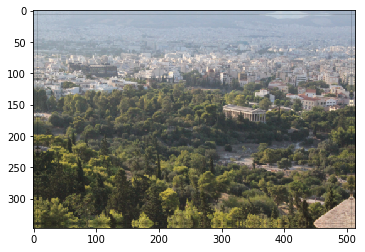

(347, 514, 3)

In [5]:
plt.imshow(image_padded)
plt.show()

image_padded.shape

### Minimum des troix canaux

In [6]:
def black_white(im):
    """Renvoie une image en niveau de gris dont la valeur de chaque pixel est égal au minimum des canaux RGB de l'image
    
    ARGUMENTS :
    im - image sur laquelle on récupère le minimum
    """
    (N, M) = (im.shape[0], im.shape[1])
    
    # Récupération des canaux
    imrouge = im[:,:,0]
    imvert = im[:,:,1]
    imbleu = im[:,:,2]
    
    # Image finale
    imf = np.zeros((N,M))
    
    for i in range(N):
        for j in range(M):
            # minimum des troix canaux
            imf[i][j] = min(imrouge[i,j], imvert[i,j], imbleu[i,j])
    
    return imf

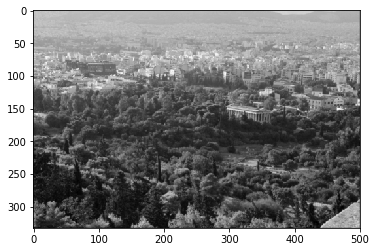

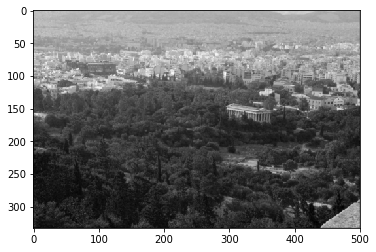

In [7]:
# Image du minimum
imt = black_white(image)

# image en niveau de gris sur canal Vert
plt.imshow(image[:,:,1], cmap='gray')
plt.show()

# Image en NB avec le min de chaque canal
plt.imshow(imt, cmap='gray')
plt.show()

### Dark Channel

In [8]:
def dark_channel(im, patchsize):
    """Calcule le Dark Channel de im selon la thèse de HE, Kaiming
    
    ARGUMENTS :
    im - image dont on veut calculer le Dark Channel
    patchsize - taille du patch qui sera appliqué sur l'image
    """
    (N, M) = (im.shape[0], im.shape[1])
    
    # Augmentation de la taille de l'image par mirror padding et calcul de l'image minimale
    imb = border_effects_continuity(im, patchsize)
    imbw = black_white(imb)
    
    # Image finale
    imf = np.zeros((N,M))
    
    # Chaque pixel prend la valeur minimale du patch dont il est le centre
    for i in range(N):
        for j in range(M):
            imf[i,j] = np.min(imbw[i:i+patchsize, j:j+patchsize])
    
    return imf

In [9]:
# Calcul du Dark Channel de notre image
im_dark = dark_channel(image, 15)

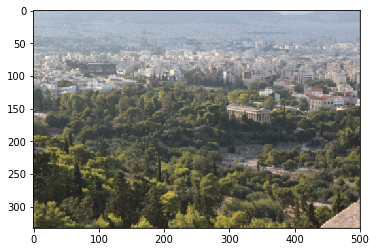

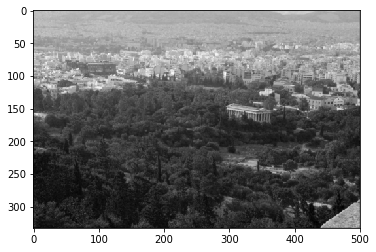

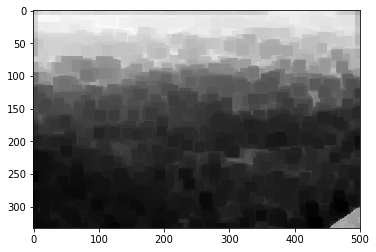

In [10]:
plt.imshow(image)
plt.show()

plt.imshow(imt, cmap='gray')
plt.show()

plt.imshow(im_dark, cmap='gray')
plt.show()

### Atmospheric Light

In [11]:
def atmosphericLight(im, patchsize):
    """Calcule la valeur de la lumière atmosphérique présente lors de la prise de l'image
    
    ARGUMENTS :
    im - image d'entrée
    patchsize - taille du patch qui sera appliqué sur l'image
    """

    # on calcule le Dark Channel de l'image
    image_dark = dark_channel(im, patchsize)
    (N, M) = (image_dark.shape[0], image_dark.shape[1])
    
    # On récupère chaque canal de l'image
    imd = image_dark.reshape((N*M, 1))
    imrouge = im[:,:,0].reshape((N*M, 1))
    imvert = im[:,:,1].reshape((N*M, 1))
    imbleu = im[:,:,2].reshape((N*M, 1))
    
    I = np.copy(imd)
    im_max_dark = np.dstack([I, I, I])
    
    # on classe les pixels du Dark Channel par ordre croissant
    liste = np.argsort(imd, axis=0)
    
    # seuil égal à 0.1% du nombre de pixels de l'image
    seuil = N * M * 0.1 / 100
    tot = 0 # compte le nombre de pixel que l'on a selectionné (doit rester inférieur à seuil)
    n = N*M - 1 #on sélectionne les plus grand valeur donc on commence par la fin de liste
    
    # Initialisation de la lumière atmosphérique
    mean = np.zeros(3)
    
    # moyenne des valeurs des pixels dans im sur les 0.1% les plus clairs dans le Dark Channel
    while(tot <= seuil): 
        index = liste[n] #index du max de l'image
                  
        im_max_dark[index,:] = [1,0,0]
        mean[0] += imrouge[index]
        mean[1] += imvert[index]
        mean[2] += imbleu[index]
        
        n = n - 1  
        tot += 1
    
    # moyenne
    mean /= seuil
    print (mean)
    
    im_max_dark = im_max_dark.reshape(im.shape)
    return im_max_dark, mean

[0.6960506  0.74625911 0.80218848]


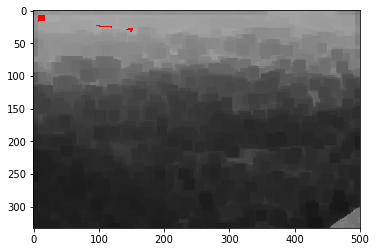

In [12]:
# Calcul de la lumière atmosphérique sur notre image
imAt, Ac = atmosphericLight(image, 15)

# Affiche les 0.1% pixels selectionnés pour la calculer
plt.imshow(imAt)
plt.show()

### Transmission map

In [13]:
# Normalisation de l'image par la valeur de la lumière atmosphérique dans celle-ci
ihaze = image/Ac

# Calcul de son Dark Channel
idark = dark_channel(ihaze, 15)

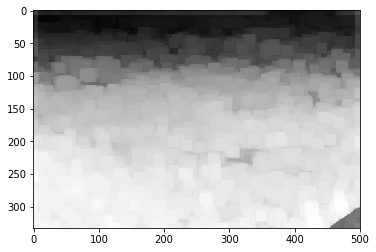

In [14]:
# Calcul de la carte de transition
t = 1 - idark

k = 0.95 #pour que la perspective aerienne soit présente
t = 1 - k*(1 - t)

plt.imshow(t, cmap='gray')
plt.show()

## Guided Filter

### 1ère méthode : Chapitre 12 de la thèse de HE, Kaiming

In [15]:
def guidedF(inputImage, guide, patchsize, eps):
    """Applique un guide filtré sur l'image inputImage guidé par guide
    
    ARGUMENTS :
    inputImage - image à filtrer
    guide - image guide qui doit donner ses contours
    patchsize - taille du patch qui sera appliqué sur l'image
    eps - terme de régularisation
    """
    t0 = time()
    (N, M) = (guide.shape[0], guide.shape[1])
    
    # Aggrandissement des images en vu d'utilisation de patchs sur celles-ci
    guideb = border_effects_continuity(guide, patchsize)
    inputImageb = border_effects_continuity(inputImage, patchsize,1)

    # image filtrée
    imf = np.zeros((N,M))
    
    # coefficients du filtre
    a = np.zeros((N,M,3))
    b = np.zeros((N,M))
    
    # calcul des coefficients du filtre
    for i in range(N):
        for j in range(M):
            # patch sur l'image sélectionnée, applati
            Iguide = guideb[i:i+patchsize, j:j+patchsize]
            Iguider = np.transpose(Iguide.reshape(patchsize*patchsize, 3))
            inputIbr = np.transpose(inputImageb[i:i+patchsize, j:j+patchsize].reshape(patchsize*patchsize))
            
            # opérations sur le patch
            sigma = np.cov(Iguider) # matrice de covariance du guide
            mu = np.mean(Iguider,axis=1) # moyenne du guide
            mup = np.mean(inputImageb[i:i+patchsize, j:j+patchsize]) # moyenne de l'image à filtrer
            
            # calcul du vecteur de covariance entre le guide et l'image
            cov = (np.sum(Iguider*inputIbr,axis=1) / (patchsize*patchsize)) - mu*mup 
            
            # coefficients du filtre
            a[i,j] = ( np.linalg.inv(sigma + eps*np.eye(3)).dot(cov) )
            b[i,j] = ( mup - a[i,j].dot(mu) )
    
    # Aggrandissement des coefficients en vu d'utilisation de patchs sur ceux-ci
    ab = border_effects_continuity(a, patchsize)
    bb = border_effects_continuity(b, patchsize,1)
    
    # Calcul de l'image filtrée avec les coeffitiens
    for i in range(N):
        for j in range(M):
            imf[i,j] = (np.mean(ab[i:i+patchsize, j:j+patchsize].reshape(patchsize*patchsize,3),axis=0).dot(guide[i,j])
            + np.mean(bb[i:i+patchsize, j:j+patchsize]))
            
    print("guidedF : done in %0.3fs" % (time() - t0))
    return imf

### 2ème méthode : Guide filtré accéléré

In [16]:
def boxfilter(img, r):
    """Calcul les boxFilters
    
    ARGUMENTS :
    img - image à filtrer
    r - moitié de la taille du patch qui sera appliqué sur l'image
    """
    rows = img.shape[0]
    cols = img.shape[1]
    imDst = np.zeros_like(img)

    imCum = np.cumsum(img, 0)
    imDst[0 : r+1, :] = imCum[r : 2*r+1, :]
    imDst[r+1 : rows-r, :] = imCum[2*r+1 : rows, :] - imCum[0 : rows-2*r-1, :]
    imDst[rows-r: rows, :] = np.tile(imCum[rows-1, :], [r, 1]) - imCum[rows-2*r-1 : rows-r-1, :]

    imCum = np.cumsum(imDst, 1)
    imDst[:, 0 : r+1] = imCum[:, r : 2*r+1]
    imDst[:, r+1 : cols-r] = imCum[:, 2*r+1 : cols] - imCum[:, 0 : cols-2*r-1]
    imDst[:, cols-r: cols] = np.tile(imCum[:, cols-1], [r, 1]).T - imCum[:, cols-2*r-1 : cols-r-1]

    return imDst

# pour une image en Noir et Blanc
def guidedfilter(I, p, r, eps):
    """Applique un guide filtré sur l'image I en noir et blanc
    
    ARGUMENTS :
    guidance image: I (should be a gray-scale image)
    filtering input image: p (should be a gray-scale/single channel image)
    local window radius: r
    regularization parameter: eps
    """
    rows = I.shape[0]
    cols = I.shape[1]
    N = boxfilter(np.ones([rows, cols]), r)

    # opérations sur l'image
    meanI = boxfilter(I, r) / N
    meanP = boxfilter(p, r) / N
    meanIp = boxfilter(I * p, r) / N
    covIp = meanIp - meanI * meanP

    meanII = boxfilter(I * I, r) / N
    varI = meanII - meanI * meanI

    # calcul des coefficients du filtre comme ci-dessus
    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = boxfilter(a, r) / N
    meanB = boxfilter(b, r) / N

    # image finale
    q = meanA * I + meanB
    return q

# pour une image couleur
def guidedfilter_color(I, p, r, eps):
    """Applique un guide filtré sur l'image I en couleur
    
    ARGUMENTS :
    guidance image: I (should be a color (RGB) image)
    filtering input image: p (should be a gray-scale/single channel image)
    local window radius: r
    regularization parameter: eps
    """
    t0 = time()
    
    rows = I.shape[0]
    cols = I.shape[1]
    
    N = boxfilter(np.ones([rows, cols]), r) # the size of each local patch; N=(2r+1)^2 except for boundary pixels.

    # operations
    meanI_r = boxfilter(I[:,:,0], r) / N
    meanI_v = boxfilter(I[:,:,1], r) / N
    meanI_b = boxfilter(I[:,:,2], r) / N
    
    meanP = boxfilter(p, r) / N
    
    meanIp_r = boxfilter(I[:,:,0] * p, r) / N
    meanIp_v = boxfilter(I[:,:,1] * p, r) / N
    meanIp_b = boxfilter(I[:,:,2] * p, r) / N

# covariance of (I, p) in each local patch.
    covIp_r = meanIp_r - meanI_r * meanP
    covIp_v = meanIp_v - meanI_v * meanP
    covIp_b = meanIp_b - meanI_b * meanP

#variance of I in each local patch: the matrix Sigma in Eqn (14).
#Note the variance in each local patch is a 3x3 symmetric matrix:
#          rr, rv, rb
#  Sigma = rv, vv, vb
#          rb, vb, bb
    meanII_r = boxfilter(I[:,:,0] * I[:,:,0], r) / N
    meanII_v = boxfilter(I[:,:,1] * I[:,:,1], r) / N
    meanII_b = boxfilter(I[:,:,2] * I[:,:,2], r) / N
    
    var_I_rr = meanII_r - meanI_r * meanI_r
    var_I_vv = meanII_v - meanI_v * meanI_v
    var_I_bb = meanII_b - meanI_b * meanI_b
    
    var_I_rv = boxfilter(I[:,:,0]*I[:,:,1], r) / N - meanI_r *  meanI_v; 
    var_I_rb = boxfilter(I[:,:,0]*I[:,:,2], r) / N - meanI_r *  meanI_b; 
    var_I_vb = boxfilter(I[:,:,1]*I[:,:,2], r) / N - meanI_v *  meanI_b; 

    # coefficients
    a = np.zeros((rows,cols,3))
    
    for x in range(cols):
        for y in range(rows):
            Sigma = [[var_I_rr[y, x], var_I_rv[y, x], var_I_rb[y, x]], [var_I_rv[y, x], var_I_vv[y, x], var_I_vb[y, x]], [var_I_rb[y, x], var_I_vb[y, x], var_I_bb[y, x]]]
            Sigma = Sigma + eps * np.eye(3);
            
            cov_Ip = [covIp_r[y, x], covIp_v[y, x], covIp_b[y, x]]
            a[y,x,:] = np.dot(cov_Ip, np.linalg.inv(Sigma + eps * np.eye(3)))
    
    b = meanP - a[:,:,0] * meanI_r - a[:,:,1] * meanI_v - a[:, :, 2] * meanI_b
    #output
    q = (boxfilter(a[:, :, 0], r)* I[:, :, 0] + boxfilter(a[:, :, 1], r)* I[:, :, 1] + boxfilter(a[:, :, 2], r)* I[:, :, 2] + boxfilter(b, r)) / N
    
    print("guidedfilter_color : done in %0.3fs" % (time() - t0))
    return q

### Multi-scale guided filter

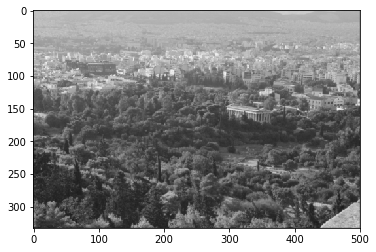

In [17]:
def rgb2gray(rgb):
    """ Transforme une image en noir et blanc
    
    ARGUMENTS :
    rgb : image à transformer
    """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# calcul le guide en noir et blanc pour le filtre guidé multi-échelle
gray = rgb2gray(image)    
gray = resize(gray, (image.shape[0], image.shape[1]), mode='constant', anti_aliasing=True)
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [18]:
### Multiscale guided filter

## Useful functions
from scipy.signal import convolve2d

# kernel
kBurt = [[.05, .25, .4, .25, .05]]
K = np.transpose(kBurt)@kBurt

# downsampling algorithm (algo 32 p.196)
def downsample(image, kernel):
    """ Sous-échantillonne une image
    
    ARGUMENTS :
    image - image à sous-échantillonner
    kernel - noyau pour homogénéiser l'image
    """
    H = image.shape[0]
    W = image.shape[1]
    h2 = math.floor(H/2)
    w2 = math.floor(W/2)
    
    u2 = convolve2d(image, kernel,'same')
    u2 = u2.reshape(image.shape)
    v = np.zeros((h2, w2))
    
    for i in range(h2):
        for j in range(w2):
            v[i][j] = u2[2*i][2*j]
    return v

# upsampling algorithm (algo 33 p.197)
def upsample(image, shape, kernel):
    """ Sur-échantillonne une image
    
    ARGUMENTS :
    image - image à sur-échantillonner
    kernel - noyau pour homogénéiser l'image
    shape - taille finale à respecter
    """
    H = image.shape[0]
    W = image.shape[1]
    
    # aggrandit l'image de 2 pixels
    upad = border_effects_continuity(image, 2, 1)
    vpad = np.zeros((2*H+4, 2*W+4))
    
    # augmente la taille de l'image
    for i in range(H+2):
        for j in range(W+2):
            vpad[2*i][2*j] = 4 * upad[i][j]
    
    # Homogénise
    vpad2 = convolve2d(vpad,kernel,'same')
    vpad2 = vpad2.reshape(vpad.shape)
    v = vpad2[2:2*H+2,2:2*W+2]
    
    # pour traiter les problèmes de taille
    v = resize(v,shape)
    return v

# computes the Gaussian pyramid of u (9.1)
def Gpyr(u, l, kernel):
    """ Pyramide gaussienne de u de manière itérative
    
    ARGUMENTS :
    u - image en entrée
    kernel - noyau pour homogénéiser l'image
    l - niveau de la pyramide
    """
    if (l==0):
        return u
    else:
        return downsample(Gpyr(u, l-1, kernel), kernel)
    return -1

# computes the Laplacian pyramid of u (9.2)
def Lpyr(u, l, lmax, kernel):
    """ Pyramide laplacienne de u de manière itérative
    
    ARGUMENTS :
    u - image en entrée
    kernel - noyau pour homogénéiser l'image
    l - niveau de la pyramide
    lmax - niveau maximal de la pyramide
    """
    if (l == lmax):
        return Gpyr(u, l, kernel)
    elif (l < lmax):
        gauss = Gpyr(u, l, kernel)
        return gauss - upsample(Gpyr(u, l+1, kernel), gauss.shape, kernel)
    return -1

# Iterated guided filter
def IGF(image, guide, patchsize, eps, T):
    """ Filtre guidé appliqué plusieurs fois
    
    ARGUMENTS :
    image - image à filtrer
    guide - guide du filtre
    patchsize - taille du patch qui sera appliqué sur l'image
    eps - terme de régularisation
    T - nombre d'itérations
    """
    z = np.copy(image)
    
    for i in range(T):
        z = guidedfilter(guide, z, patchsize, eps)
    
    return z

In [19]:
### Multi-scale guided filter

## Algorithm
def MGFdh(image, guide, r, T, eps, lmax, kernel):
    """ Filtre guidé multi-échelle
    
    ARGUMENTS :
    image - image à filtrer
    guide - guide du filtre
    r - taille du patch qui sera appliqué sur l'image
    eps - terme de régularisation
    T - nombre d'itérations
    lmax - nombre de niveau maximal dans les pyramides
    kernel - noyau pour homogénéiser les niveaux des pyramides
    """
    
    z = Lpyr(image, lmax, lmax, kernel)
    z = IGF(z, Gpyr(guide, lmax, kernel), r, eps, T)
    
    for l in range(lmax-1,-1,-1):
        lapl = Lpyr(image, l, lmax, kernel)
        z = upsample(z, lapl.shape, kernel) + lapl
        eps = eps / (l+1)
        z = IGF(z, Gpyr(guide, l, kernel), r, eps, T)
    
    return z

### Illustration des pyramides gaussiennes et laplaciennes sur notre guide

/Applications/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Applications/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


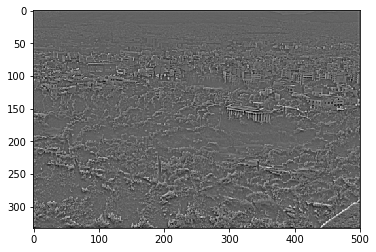

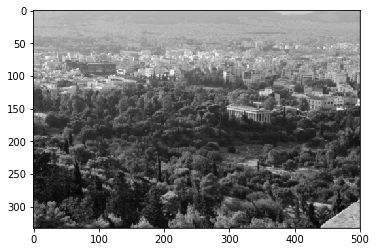

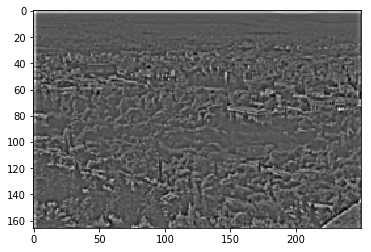

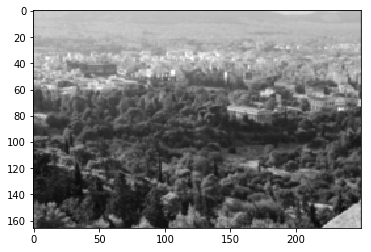

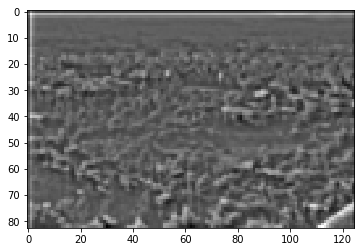

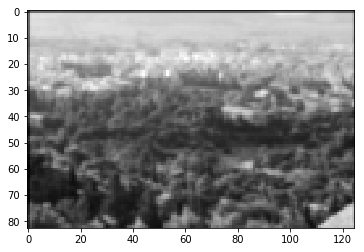

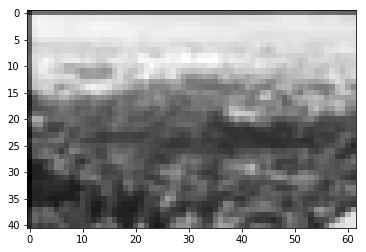

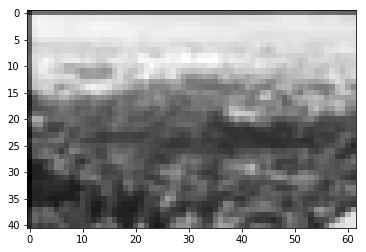

In [20]:
# Sur 4 niveaux, calcul de la pyramide laplacienne puis gaussienne et affichage
for i in range(4):
    plt.imshow(Lpyr(gray, i, 3, K), cmap='gray')
    plt.show()
    
    plt.imshow(Gpyr(gray, i, K), cmap='gray')
    plt.show()

### Calcul des différents filtres sur notre carte de transition

In [21]:
# Calcul du premier filtre guidé sur la carte de transition
im_filter = guidedF(t, image, 15, 0.01)

guidedF : done in 41.443s


In [22]:
# Calcul du filtre guidé accéléré sur la carte de transition
im_filter2 = guidedfilter_color(image, t, 7, 0.01) 

guidedfilter_color : done in 7.149s


In [23]:
### Méthode du filtrage guidé avec OpenCV

#import cv2
#from cv2.ximgproc import guidedFilter
#outimage = np.zeros((t.shape[0],t.shape[1],1)).astype(np.float32)
#dst = guidedFilter(image.astype(np.float32), t.astype(np.float32), 10, 15, 0.01) 

In [24]:
# Calcul du filtre guidé multi-échelle sur la carte de transition
MS_filter = MGFdh(t, gray, 5, 1, 0.001, 2, K)

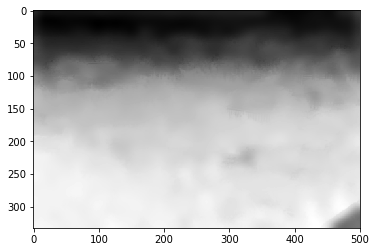

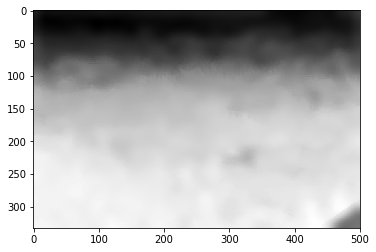

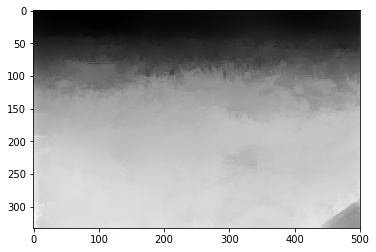

In [25]:
# Affichage des différents résultats
plt.imshow(im_filter,cmap='gray')
plt.show()

plt.imshow(im_filter2,cmap='gray')
plt.show()

plt.imshow(MS_filter,cmap='gray')
plt.show()

#plt.imshow(dst,cmap='gray')
#plt.show()

## Radiance J

Calcul de l'image débrumée

In [26]:
(N, M) = (image.shape[0], image.shape[1])

# Différentes radiances avec chaque carte de transition
radiance = np.zeros((N,M,3), dtype='float')
radiance2 = np.zeros((N,M,3), dtype='float')
radiance3 = np.zeros((N,M,3), dtype='float')
radiance4 = np.zeros((N,M,3), dtype='float')
radiance5 = np.zeros((N,M,3), dtype='float')

# valeur minimale que doit prendre la lumière atmosphérique
t0 = 0.1

for i in range(N):
    for j in range(M):
        radiance[i,j] = (image[i,j] - Ac)/max(t[i,j], t0) + Ac
        radiance2[i,j] = (image[i,j] - Ac)/max(im_filter[i,j], t0) + Ac
        radiance3[i,j] = (image[i,j] - Ac)/max(im_filter2[i,j], t0) + Ac
        radiance4[i,j] = (image[i,j] - Ac)/max(MS_filter[i,j], t0) + Ac
        #radiance5[i,j] = (image[i,j] - Ac)/max(dst[i,j], t0) + Ac

## Adaptation de la dynamique de l'image obtenue

In [27]:
# Dans la thèse, l'auteur conseillait de donner la même moyenne aux deux images
m1 = np.mean(image)
m2 = np.mean(radiance)
m3 = np.mean(radiance2)
m4 = np.mean(radiance3)
m5 = np.mean(radiance4)
m6 = np.mean(radiance5)

m = m1/m2
ma = m1/m3
mb = m1/m4
mc = m1/m5
md = m1/m6

radiance = m*radiance
radiance = (radiance-np.min(radiance))/(np.max(radiance)-np.min(radiance))

radiance2 = ma*radiance2
radiance2 = (radiance2-np.min(radiance2))/(np.max(radiance2)-np.min(radiance2))

radiance3 = mb*radiance3
radiance3 = (radiance3-np.min(radiance3))/(np.max(radiance3)-np.min(radiance3))

radiance4 = mc*radiance4
radiance4 = (radiance4-np.min(radiance4))/(np.max(radiance4)-np.min(radiance4))

radiance5 = md*radiance5
radiance5 = (radiance5-np.min(radiance5))/(np.max(radiance5)-np.min(radiance5))

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


### Algorithme du Simplest Color Balance

In [28]:
# Simplest color balance
def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)
    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)
    return matrix

def simplest_cb(img, percent):
    """ Adapte la dynamique de l'image en faisant dépasser de percent
    
    ARGUMENTS :
    img - image à traiter
    percent - pourcentage des valeurs des pixels à faire dépasser en dessous de 0 et au dessus de 1
    """
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100
    half_percent = percent / 200.0
    
    # Separation of the canals
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    channels = [r, g, b]
    out_channels = []
    
    # for each channel
    for channel in channels:
        assert len(channel.shape) == 2
        
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)
        
        assert len(flat.shape) == 1
        flat = np.sort(flat)
        n_cols = flat.shape[0]
        low_val = flat[int(math.floor(n_cols * half_percent))]
        high_val = flat[int(math.ceil( n_cols * (1.0 - half_percent)))]
        print ("Lowval: ", low_val)
        print ("Highval: ", high_val)
        
        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        
        # scale the channel
        normalized = (thresholded - np.min(thresholded)) / (np.max(thresholded) - np.min(thresholded))
        out_channels.append(normalized)
    
    # Output image
    out_img = np.zeros(img.shape)
    out_img[:,:,0] = out_channels[0]
    out_img[:,:,1] = out_channels[1]
    out_img[:,:,2] = out_channels[2]
    return out_img

Lowval:  0.01034277416355531
Highval:  0.727855570183296
Lowval:  0.016852419333977957
Highval:  0.6485445886748286
Lowval:  0.0042117171074668594
Highval:  0.5586436007779657


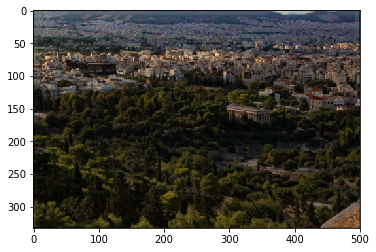

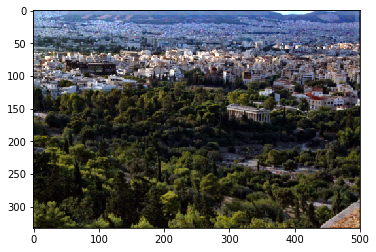

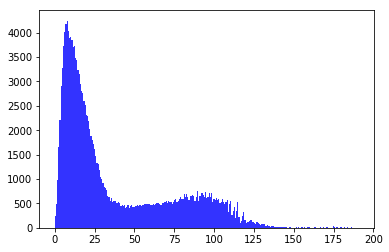

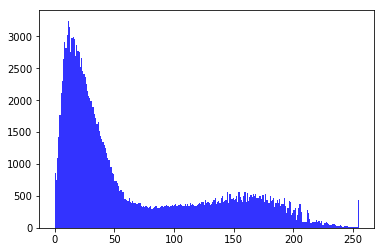

In [29]:
# Application du Simplest Color Balance à l'image dehazed
out = simplest_cb(radiance, 0.5)

# avant
plt.imshow(radiance)
plt.show()

# après
plt.imshow(out)
plt.show()

#histogrammes du canal bleu
plt.hist(255*radiance[:, :, 2].reshape(radiance.shape[0]*radiance.shape[1]),bins=255,color="blue",alpha=0.8)
plt.show()

plt.hist(255*out[:, :, 2].reshape(out.shape[0]*out.shape[1]),bins=255,color="blue",alpha=0.8)
plt.show()

## Affichage des résultats

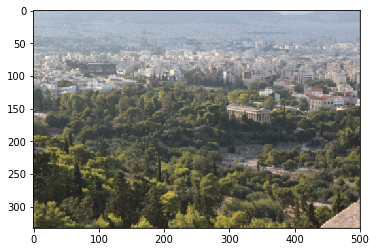

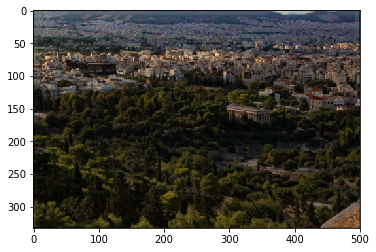

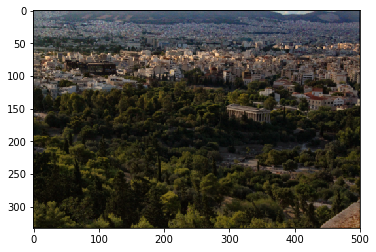

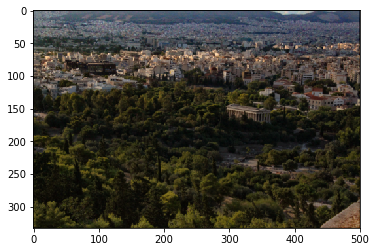

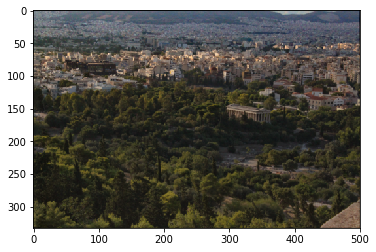

In [30]:
# Image avec brouillard
plt.imshow(image)
plt.show()

# Image dehazed sans filtre
plt.imshow(radiance)
plt.show()

# Image dehazed avec filtre guidé
plt.imshow(radiance2)
plt.show()

# Image dehazed avec filtre guidé accéléré
plt.imshow(radiance3)
plt.show()

# Image dehazed avec filtre guidé multi-échelle
plt.imshow(radiance4)
plt.show()

In [31]:
#plt.imsave('Results/trees_500_withfilter3.jpg',radiance4)
#plt.imsave('Results/trees_500_MSfilter.jpg',MS_filter,cmap='gray')